# Create a normalized database (3NF).


In [1]:
import pandas as pd
import sqlite3
from sqlite3 import Error
import os

# Function to create a database connecti`on
def create_connection(db_file, delete_db=False):
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

# Function to create tables
def create_table(conn, create_table_sql, drop_table_name=None):
    if drop_table_name:  # Drop table if specified
        try:
            c = conn.cursor()
            c.execute(f"DROP TABLE IF EXISTS {drop_table_name}")
        except Error as e:
            print(e)

    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

In [2]:
# Database and file paths
db_name = '/Users/rohanjain/Desktop/Sem1/Prog_DB/Final project/heart_disease_database.db'
csv_file_path = '/Users/rohanjain/Desktop/Sem1/Prog_DB/Final project/heart_disease.csv'

# Load the CSV data
df = pd.read_csv(csv_file_path)

# Split the data into normalized tables
# Patient_Info Table
patient_info = df[['age', 'sex']].copy()
patient_info['patient_id'] = range(1, len(patient_info) + 1)

# Medical_Record Table
medical_record = df[['chest pain type', 'resting bp s', 'cholesterol', 'fasting blood sugar']].copy()
medical_record['patient_id'] = range(1, len(medical_record) + 1)

# Test_Results Table
test_results = df[['resting ecg', 'max heart rate', 'exercise angina', 'oldpeak', 'ST slope']].copy()
test_results['patient_id'] = range(1, len(test_results) + 1)

# Diagnosis Table
diagnosis = df[['target']].copy()
diagnosis['patient_id'] = range(1, len(diagnosis) + 1)

In [3]:
# Create database connection
conn = create_connection(db_name, delete_db=True)

# Create tables
create_table(conn, """
CREATE TABLE Patient_Info (
    patient_id INTEGER PRIMARY KEY,
    age INTEGER,
    sex INTEGER
)
""", drop_table_name="Patient_Info")

create_table(conn, """
CREATE TABLE Medical_Record (
    patient_id INTEGER PRIMARY KEY,
    [chest pain type] INTEGER,
    [resting bp s] INTEGER,
    cholesterol INTEGER,
    [fasting blood sugar] INTEGER
)
""", drop_table_name="Medical_Record")

create_table(conn, """
CREATE TABLE Test_Results (
    patient_id INTEGER PRIMARY KEY,
    [resting ecg] INTEGER,
    [max heart rate] INTEGER,
    [exercise angina] INTEGER,
    oldpeak REAL,
    [ST slope] INTEGER
)
""", drop_table_name="Test_Results")

create_table(conn, """
CREATE TABLE Diagnosis (
    patient_id INTEGER PRIMARY KEY,
    target INTEGER
)
""", drop_table_name="Diagnosis")

# Write SQL join statement to fetch data from the database and into Pandas DataFrame.

In [4]:
# Populate tables
patient_info.to_sql('Patient_Info', conn, if_exists='replace', index=False)
medical_record.to_sql('Medical_Record', conn, if_exists='replace', index=False)
test_results.to_sql('Test_Results', conn, if_exists='replace', index=False)
diagnosis.to_sql('Diagnosis', conn, if_exists='replace', index=False)

print("Database tables created and populated.")

# Join query to combine the four tables
query = """
SELECT 
    p.patient_id,
    p.age,
    p.sex,
    m.[chest pain type],
    m.[resting bp s],
    m.cholesterol,
    m.[fasting blood sugar],
    t.[resting ecg],
    t.[max heart rate],
    t.[exercise angina],
    t.oldpeak,
    t.[ST slope],
    d.target
FROM 
    Patient_Info p
JOIN 
    Medical_Record m ON p.patient_id = m.patient_id
JOIN 
    Test_Results t ON p.patient_id = t.patient_id
JOIN 
    Diagnosis d ON p.patient_id = d.patient_id;
"""

# Execute the query and fetch the data
df_combined = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

Database tables created and populated.


# Explore the data using yprofile and correlation matrix. Make observations about features, distributions, capped values, and missing values. Create a list of data cleanup tasks.

In [5]:
df = df_combined
df.head()

,patient_id,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,1,40,1,2,140,289,0,0,172,0,0.0,1,0
1,2,49,0,3,160,180,0,0,156,0,1.0,2,1
2,3,37,1,2,130,283,0,1,98,0,0.0,1,0
3,4,48,0,4,138,214,0,0,108,1,1.5,2,1
4,5,54,1,3,150,195,0,0,122,0,0.0,1,0


In [6]:
df.shape

(1190, 13)

In [7]:
def clean_column_names(df):
    df.columns = df.columns.str.replace(' ', '_').str.lower()
    return df

df = clean_column_names(df)

df.head()

,patient_id,age,sex,chest_pain_type,resting_bp_s,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,oldpeak,st_slope,target
0,1,40,1,2,140,289,0,0,172,0,0.0,1,0
1,2,49,0,3,160,180,0,0,156,0,1.0,2,1
2,3,37,1,2,130,283,0,1,98,0,0.0,1,0
3,4,48,0,4,138,214,0,0,108,1,1.5,2,1
4,5,54,1,3,150,195,0,0,122,0,0.0,1,0


In [8]:
print(df.isnull().sum())

patient_id             0
age                    0
sex                    0
chest_pain_type        0
resting_bp_s           0
cholesterol            0
fasting_blood_sugar    0
resting_ecg            0
max_heart_rate         0
exercise_angina        0
oldpeak                0
st_slope               0
target                 0
dtype: int64


In [9]:
print(df.describe())

        patient_id          age          sex  chest_pain_type  resting_bp_s  \
count  1190.000000  1190.000000  1190.000000      1190.000000   1190.000000   
mean    595.500000    53.720168     0.763866         3.232773    132.153782   
std     343.667717     9.358203     0.424884         0.935480     18.368823   
min       1.000000    28.000000     0.000000         1.000000      0.000000   
25%     298.250000    47.000000     1.000000         3.000000    120.000000   
50%     595.500000    54.000000     1.000000         4.000000    130.000000   
75%     892.750000    60.000000     1.000000         4.000000    140.000000   
max    1190.000000    77.000000     1.000000         4.000000    200.000000   

       cholesterol  fasting_blood_sugar  resting_ecg  max_heart_rate  \
count  1190.000000          1190.000000  1190.000000     1190.000000   
mean    210.363866             0.213445     0.698319      139.732773   
std     101.420489             0.409912     0.870359       25.517636   


In [10]:
print(df.dtypes)

patient_id               int64
age                      int64
sex                      int64
chest_pain_type          int64
resting_bp_s             int64
cholesterol              int64
fasting_blood_sugar      int64
resting_ecg              int64
max_heart_rate           int64
exercise_angina          int64
oldpeak                float64
st_slope                 int64
target                   int64
dtype: object


In [11]:
# Value counts for categorical columns
categorical_columns = ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'resting_ecg', 'exercise_angina', 'st_slope', 'target']
for col in categorical_columns:
    print(f"Value Counts for {col}:")
    print(df[col].value_counts())
    print()


Value Counts for sex:
sex
1    909
0    281
Name: count, dtype: int64

Value Counts for chest_pain_type:
chest_pain_type
4    625
3    283
2    216
1     66
Name: count, dtype: int64

Value Counts for fasting_blood_sugar:
fasting_blood_sugar
0    936
1    254
Name: count, dtype: int64

Value Counts for resting_ecg:
resting_ecg
0    684
2    325
1    181
Name: count, dtype: int64

Value Counts for exercise_angina:
exercise_angina
0    729
1    461
Name: count, dtype: int64

Value Counts for st_slope:
st_slope
2    582
1    526
3     81
0      1
Name: count, dtype: int64

Value Counts for target:
target
1    629
0    561
Name: count, dtype: int64



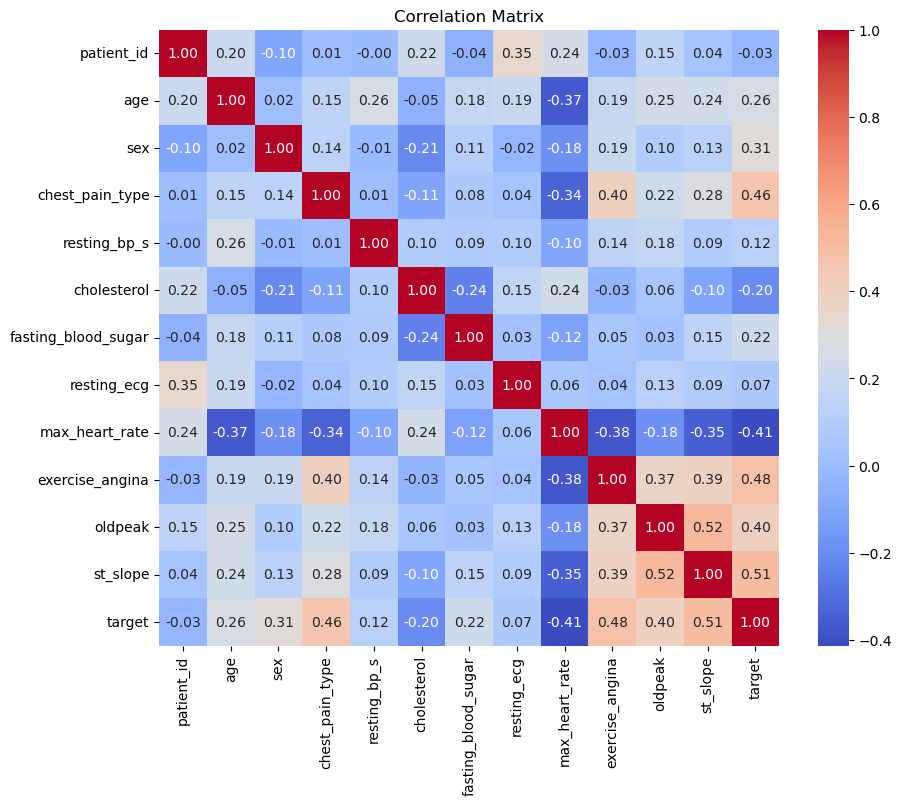

In [12]:
# Display correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()


In [13]:
correlation_matrix = df.corr()

# Print the Correlation Table
print("Correlation Table:")
print(correlation_matrix)

Correlation Table:
                     patient_id       age       sex  chest_pain_type  \
patient_id             1.000000  0.204412 -0.101410         0.008365   
age                    0.204412  1.000000  0.015096         0.149055   
sex                   -0.101410  0.015096  1.000000         0.138405   
chest_pain_type        0.008365  0.149055  0.138405         1.000000   
resting_bp_s          -0.002289  0.257692 -0.006443         0.009466   
cholesterol            0.217898 -0.046472 -0.208441        -0.109396   
fasting_blood_sugar   -0.043809  0.178923  0.110961         0.076492   
resting_ecg            0.345645  0.194595 -0.022225         0.035705   
max_heart_rate         0.244382 -0.368676 -0.181837        -0.337491   
exercise_angina       -0.026119  0.188095  0.194380         0.403428   
oldpeak                0.147227  0.245093  0.096390         0.224106   
st_slope               0.044905  0.237749  0.127913         0.276949   
target                -0.026617  0.262029  0.

Observations:

    sex:
        76% are males (1), while 24% are females (0).
        No significant imbalance requiring stratification for this attribute.

    chest_pain_type:
        Class 4 (asymptomatic) is the most common (52%), followed by 3 (24%), 2 (18%), and 1 (5%).

    exercise_angina:
        Majority (61%) of the data represents individuals without exercise-induced angina (0), while 39% have it (1).
        The imbalance is not severe but could be stratified if necessary.

    target:
    The target variable is also balanced but we will still stratify to proportionally represnt.

In [14]:
#Getting alot of issues while pip installing for y profile, hence skipping
#Had to uninstall anaconda since alot of versions got changed

In [15]:
# Basic statistics
print(df.describe())

        patient_id          age          sex  chest_pain_type  resting_bp_s  \
count  1190.000000  1190.000000  1190.000000      1190.000000   1190.000000   
mean    595.500000    53.720168     0.763866         3.232773    132.153782   
std     343.667717     9.358203     0.424884         0.935480     18.368823   
min       1.000000    28.000000     0.000000         1.000000      0.000000   
25%     298.250000    47.000000     1.000000         3.000000    120.000000   
50%     595.500000    54.000000     1.000000         4.000000    130.000000   
75%     892.750000    60.000000     1.000000         4.000000    140.000000   
max    1190.000000    77.000000     1.000000         4.000000    200.000000   

       cholesterol  fasting_blood_sugar  resting_ecg  max_heart_rate  \
count  1190.000000          1190.000000  1190.000000     1190.000000   
mean    210.363866             0.213445     0.698319      139.732773   
std     101.420489             0.409912     0.870359       25.517636   


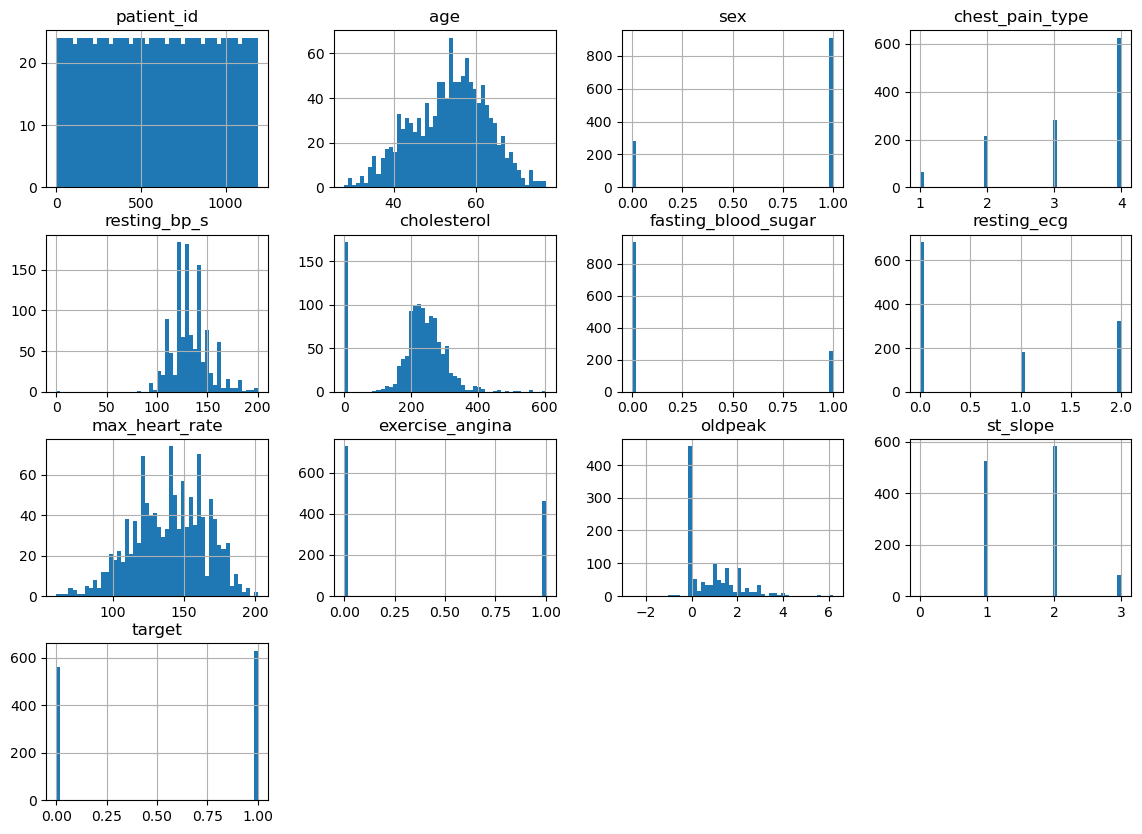

In [16]:
import matplotlib.pyplot as plt

df.hist(bins=50, figsize=(14, 10))
plt.show()

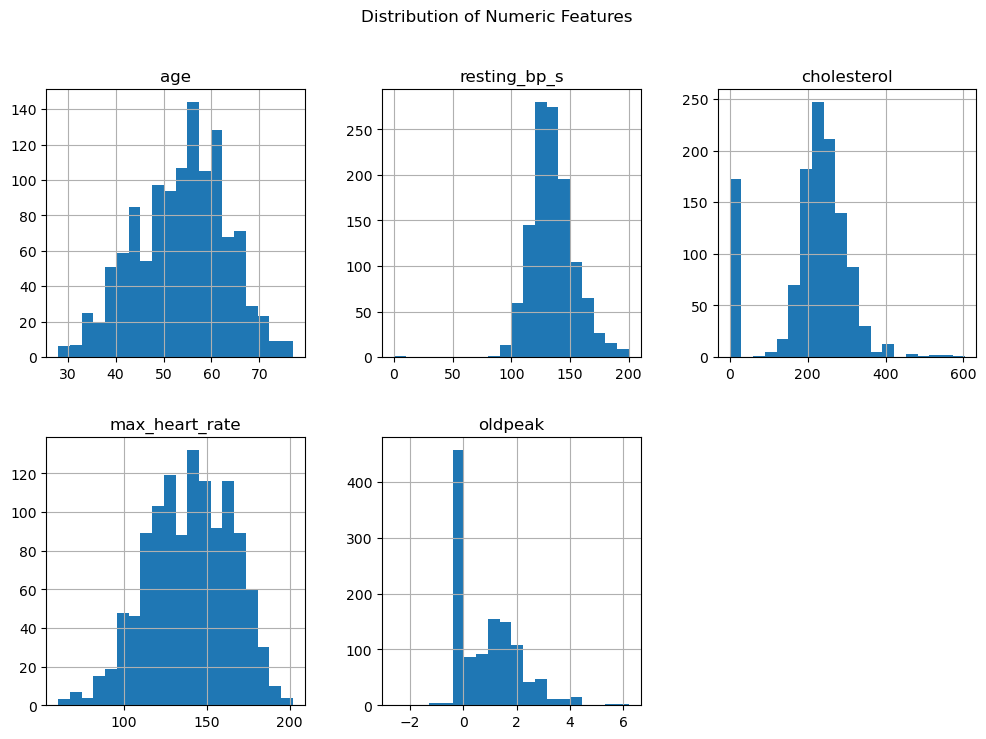

In [17]:
# Plot histograms for numeric features
numeric_features = ['age', 'resting_bp_s', 'cholesterol', 'max_heart_rate', 'oldpeak']
df[numeric_features].hist(bins=20, figsize=(12, 8), layout=(2, 3))
plt.suptitle('Distribution of Numeric Features')
plt.show()


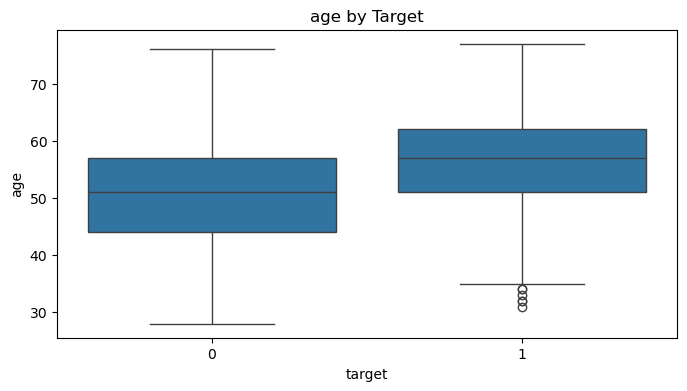

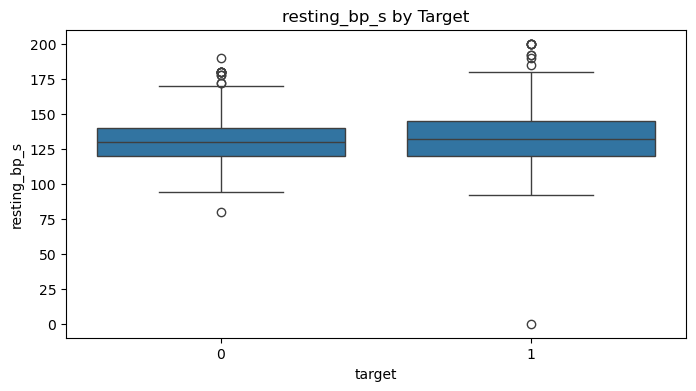

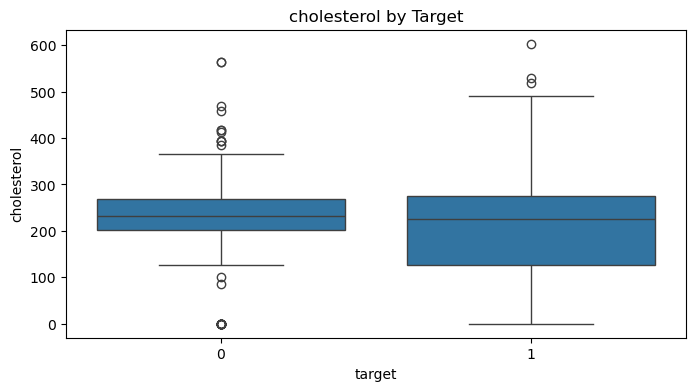

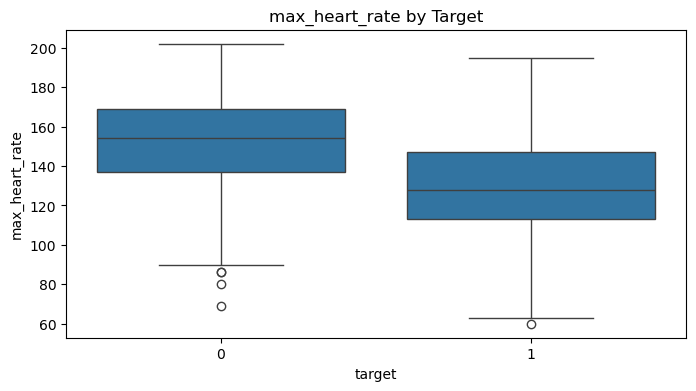

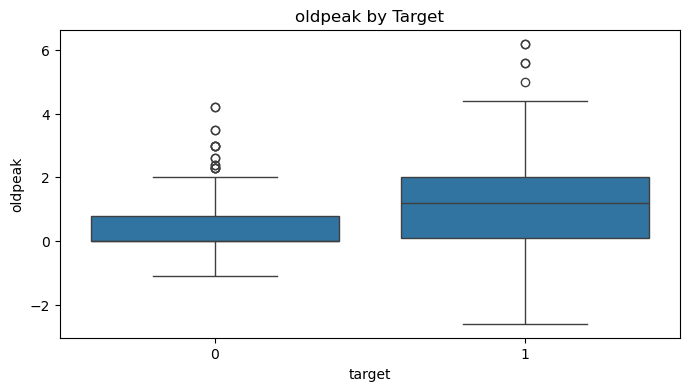

In [18]:
# Boxplots for numeric features by target
for col in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x='target', y=col)
    plt.title(f'{col} by Target')
    plt.show()


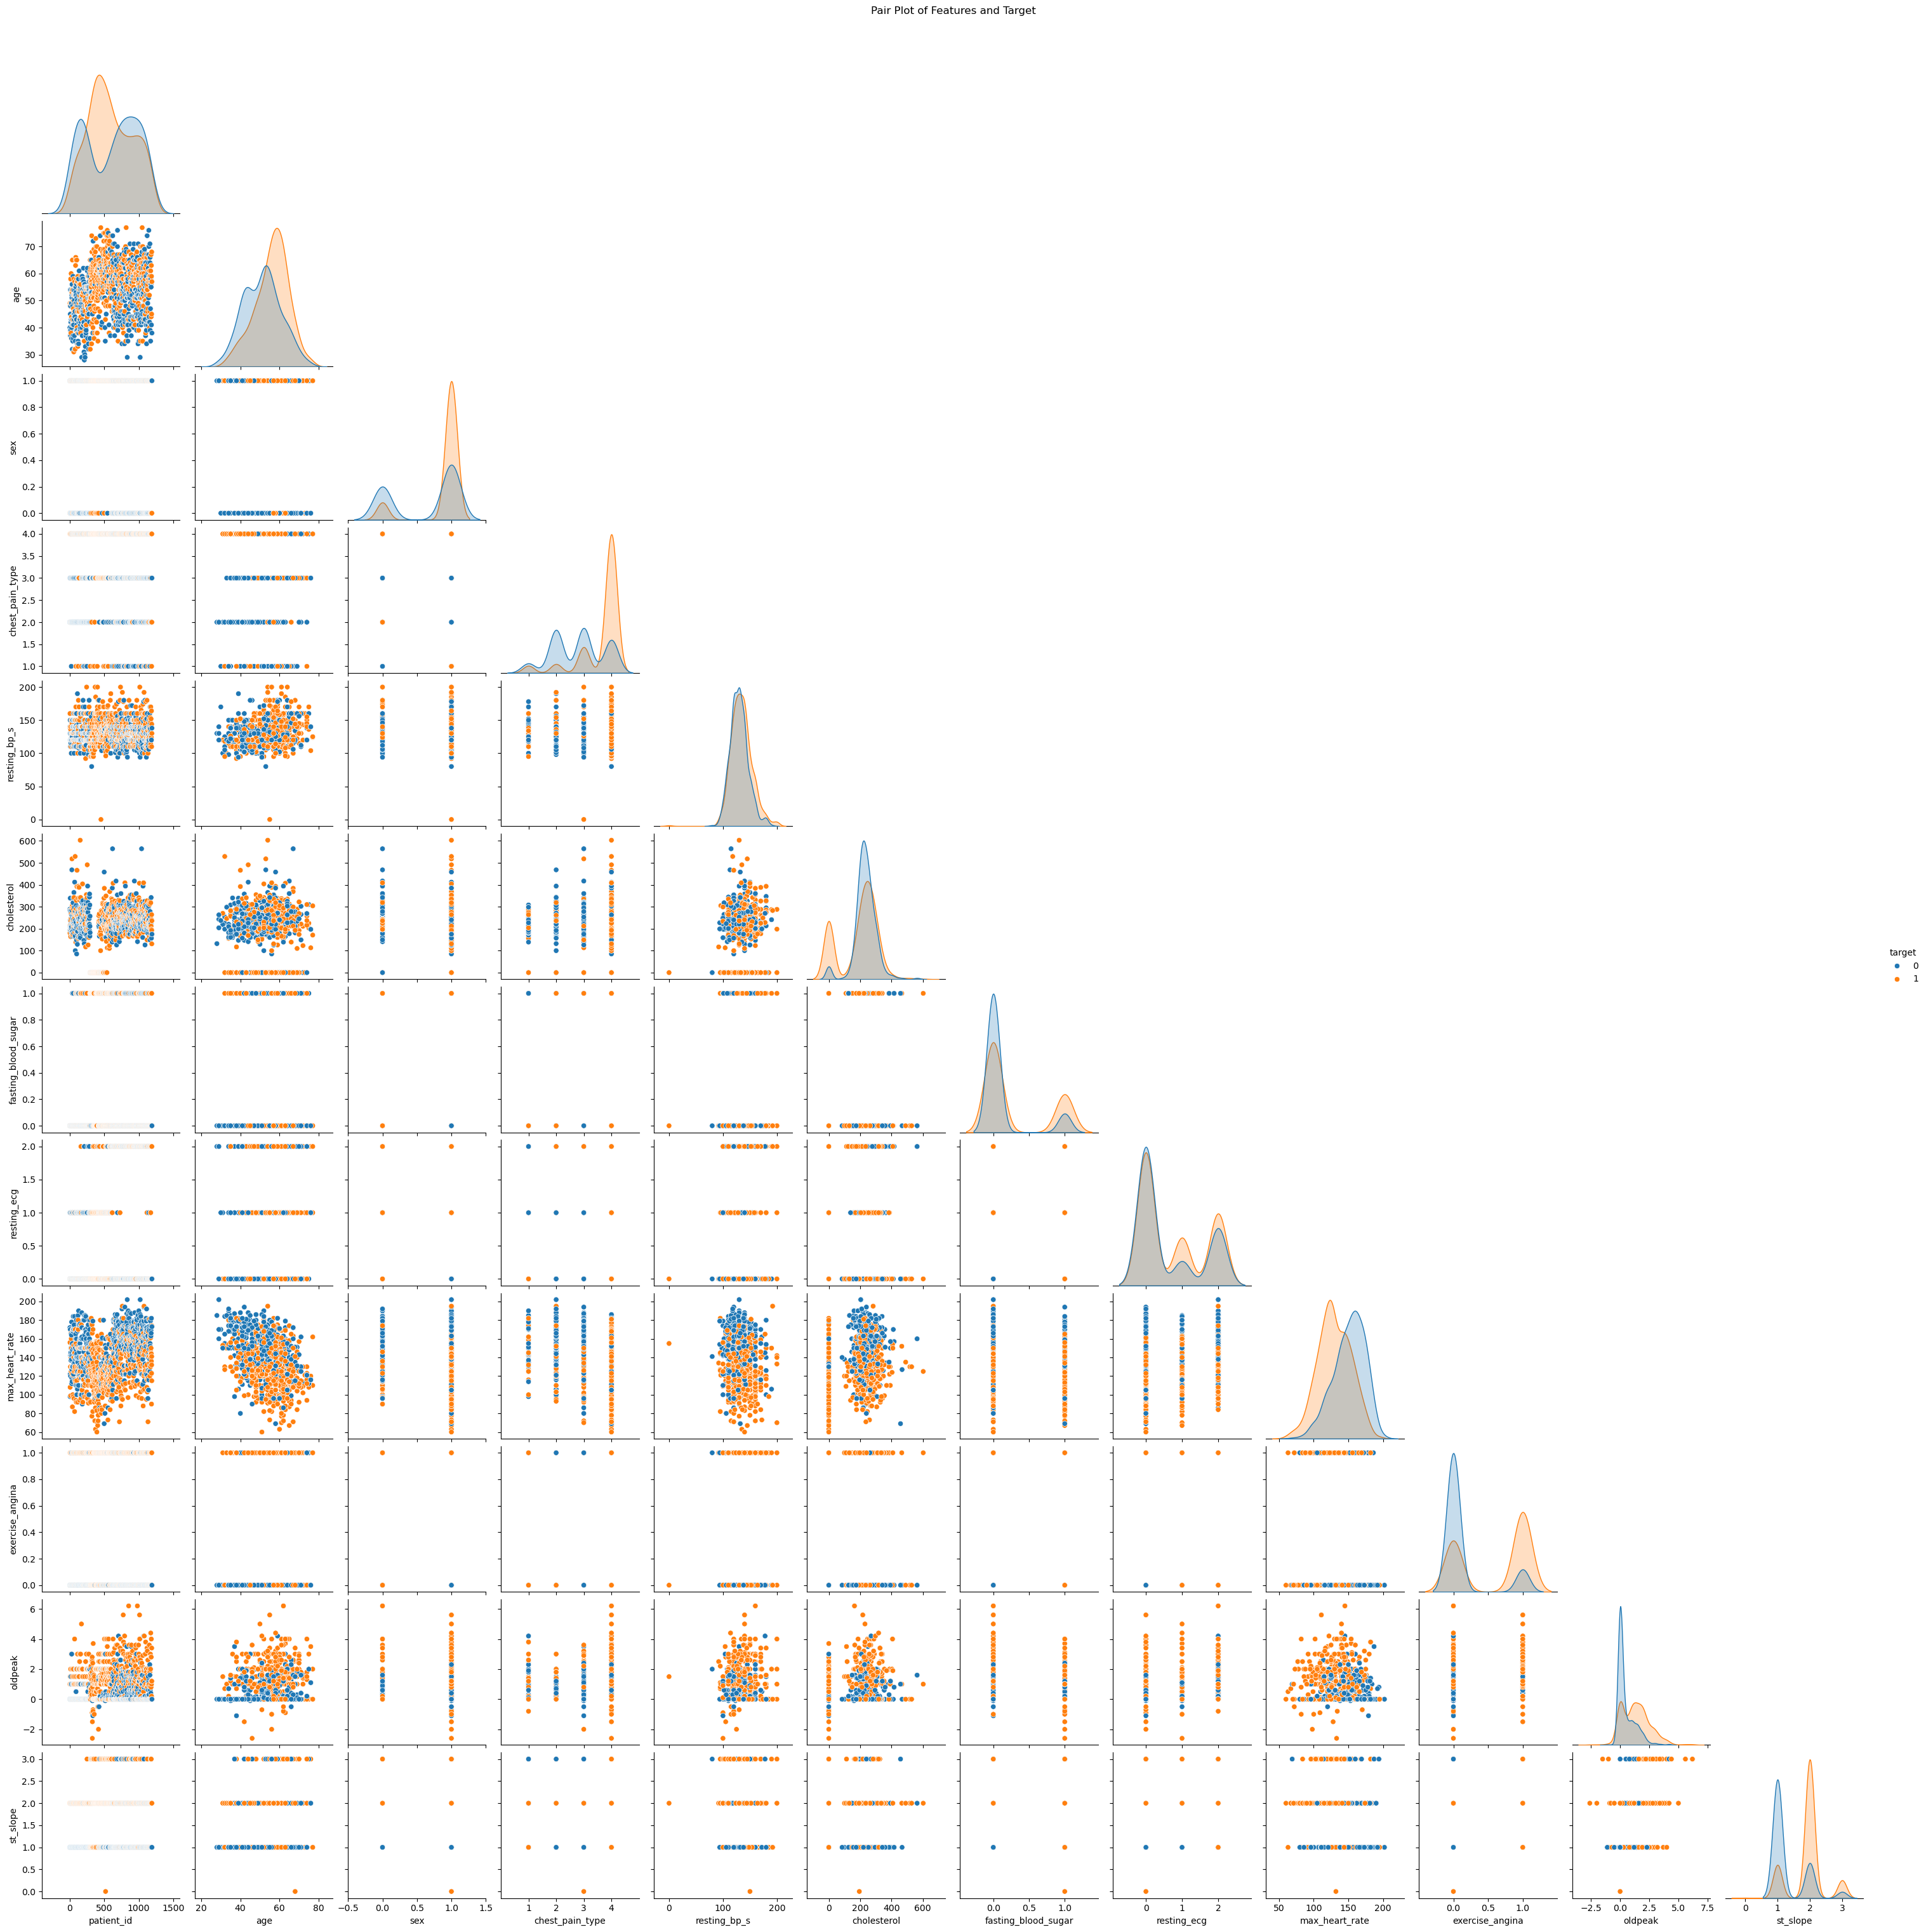

In [19]:
# Pair plot
sns.pairplot(df, hue='target', diag_kind='kde', corner=True)
plt.suptitle('Pair Plot of Features and Target', y=1.02)
plt.show()


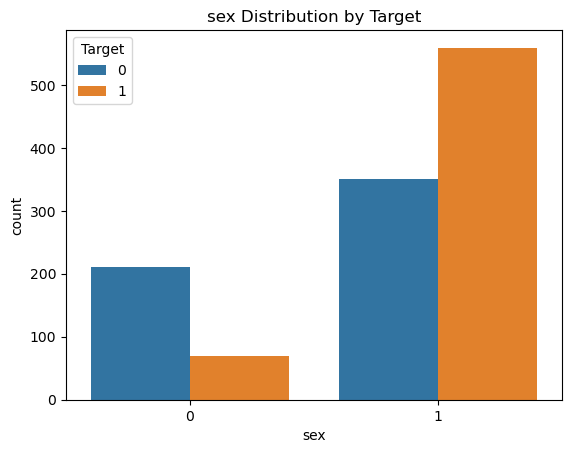

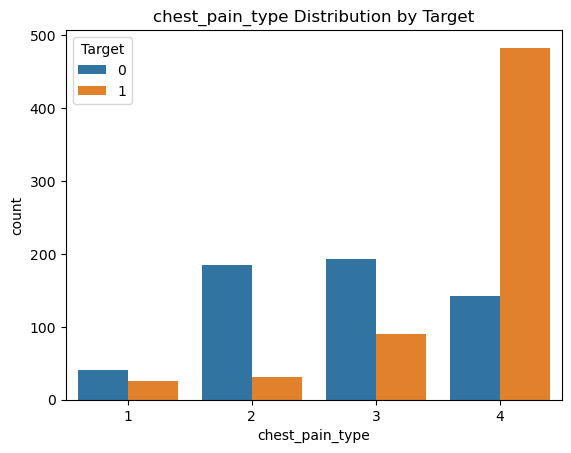

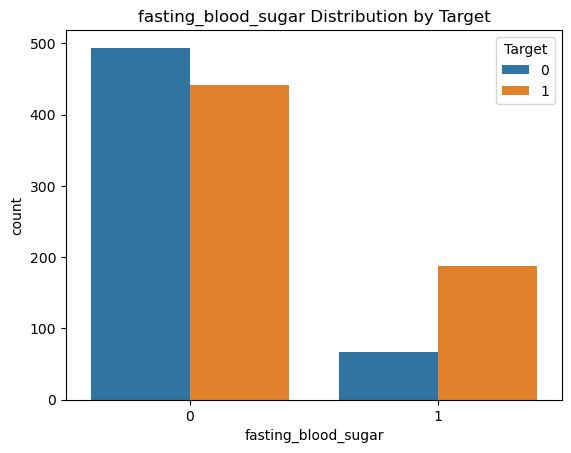

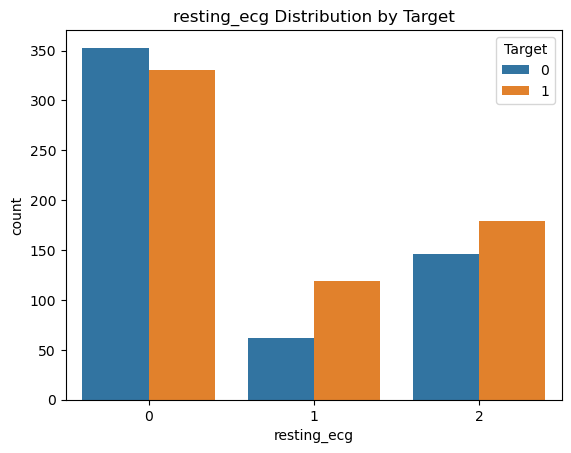

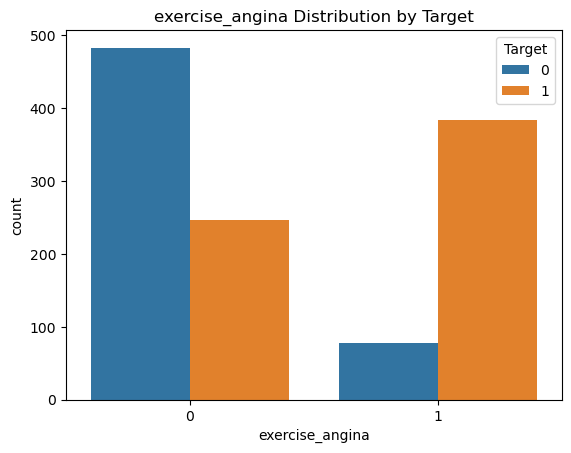

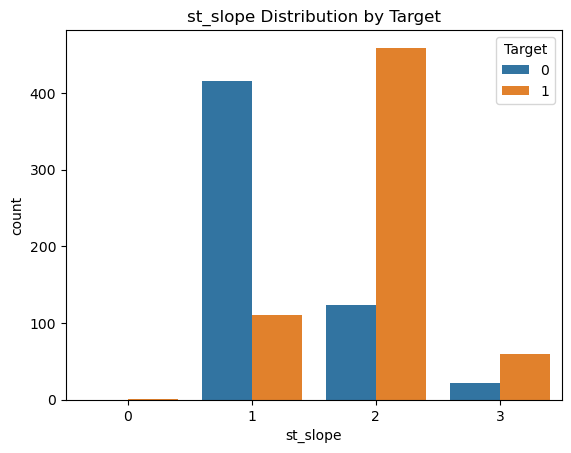

In [20]:
# Cat features distribution
categorical_features = ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'resting_ecg', 'exercise_angina', 'st_slope']
for col in categorical_features:
    sns.countplot(data=df, x=col, hue='target')
    plt.title(f'{col} Distribution by Target')
    plt.legend(title='Target')
    plt.show()


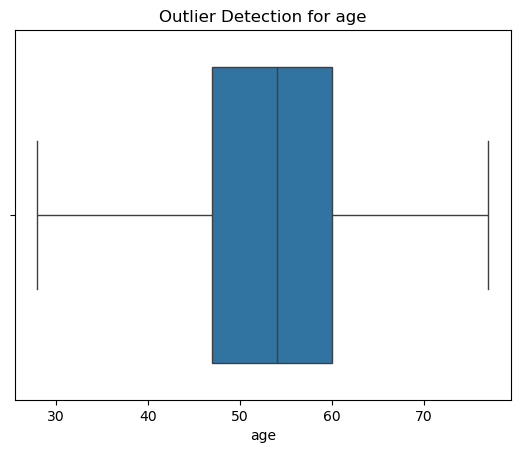

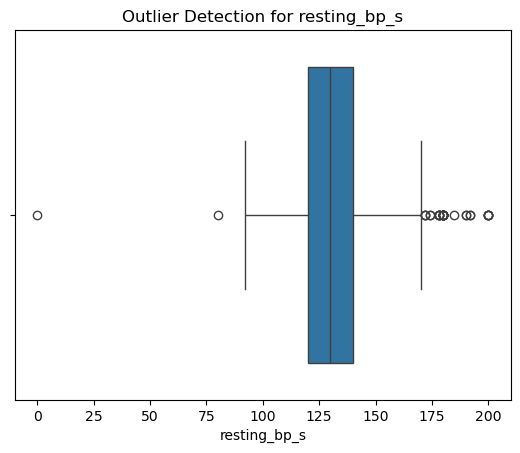

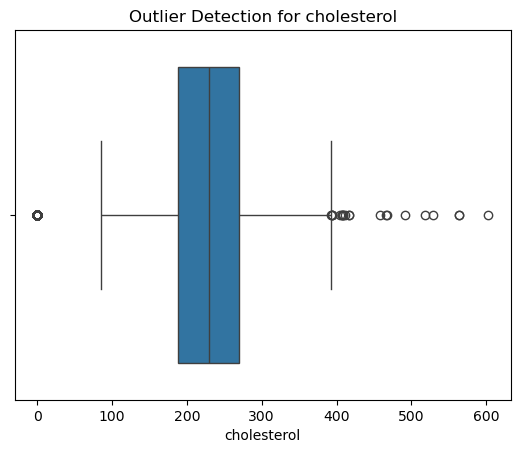

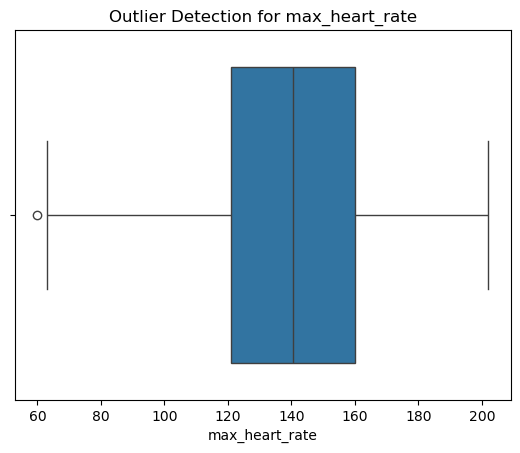

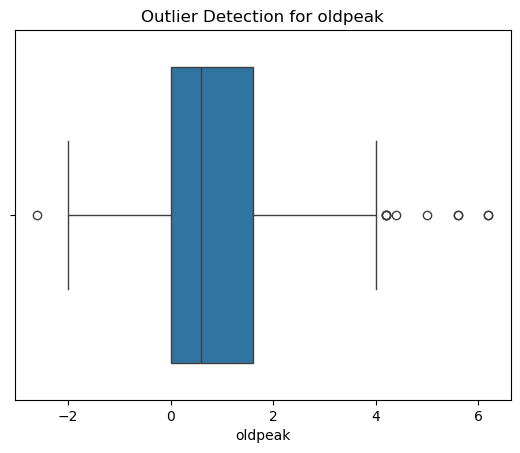

In [21]:
# Boxplots for outlier detection
for col in numeric_features:
    sns.boxplot(data=df, x=col)
    plt.title(f'Outlier Detection for {col}')
    plt.show()


In [22]:
# Observation - Need to handle these

# patient_id: Irrelevant for modeling (acts as an identifier).
# resting_ecg: Very weak correlation with target
# Consider dropping one of st_slope or oldpeak due to high inter-correlation (0.524).
# resting_bp_s values of 0.
# cholesterol values of 0.
# oldpeak values below 0.

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import mlflow



# Replace 0 values in 'resting_bp_s' and 'cholesterol' with NaN for imputation
df['resting_bp_s'] = df['resting_bp_s'].replace(0, np.nan)
df['cholesterol'] = df['cholesterol'].replace(0, np.nan)

# Replace negative values in 'oldpeak' with 0
df['oldpeak'] = df['oldpeak'].clip(lower=0)

# Impute missing values with median
df['resting_bp_s'].fillna(df['resting_bp_s'].median(), inplace=True)
df['cholesterol'].fillna(df['cholesterol'].median(), inplace=True)

# Drop irrelevant columns
df = df.drop(columns=['patient_id'], errors='ignore')

# Step 2: Preprocessing Pipeline
numeric_features = ['age', 'resting_bp_s', 'cholesterol', 'max_heart_rate', 'oldpeak']
categorical_features = ['sex', 'fasting_blood_sugar', 'exercise_angina', 'chest_pain_type', 'resting_ecg', 'st_slope']

# Define transformations
log_transformer = FunctionTransformer(np.log1p, validate=True)  # Log transformation (log(x+1) to handle zeros)
scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)


/var/folders/88/h6q1hd0558n2s59lz2g0xx640000gn/T/ipykernel_61598/1710457563.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['resting_bp_s'].fillna(df['resting_bp_s'].median(), inplace=True)
/var/folders/88/h6q1hd0558n2s59lz2g0xx640000gn/T/ipykernel_61598/1710457563.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

# Explore the data to determine if you need to stratify it by some attribute when doing train/test split. Perform the train/test split.

Distribution of target variable:
target
1    0.528571
0    0.471429
Name: proportion, dtype: float64


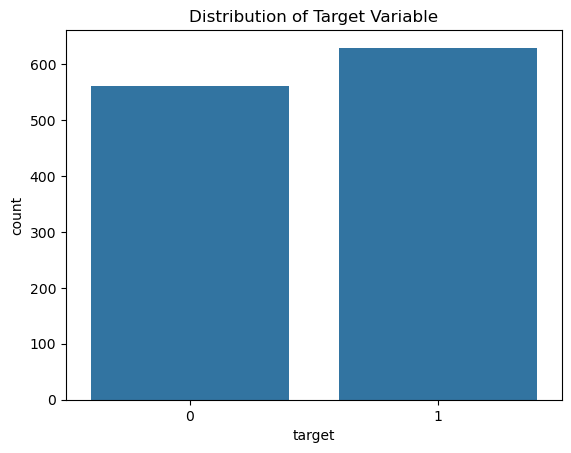

In [24]:
# Check the distribution of the target variable
print("Distribution of target variable:")
print(df['target'].value_counts(normalize=True))

# Visualize the distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='target', data=df)
plt.title("Distribution of Target Variable")
plt.show()


In [25]:
# Distribution of categorical variables
categorical_columns = ['sex', 'chest_pain_type', 'exercise_angina']

for col in categorical_columns:
    print(f"Distribution of {col}:")
    print(df[col].value_counts(normalize=True))
    print()


Distribution of sex:
sex
1    0.763866
0    0.236134
Name: proportion, dtype: float64

Distribution of chest_pain_type:
chest_pain_type
4    0.525210
3    0.237815
2    0.181513
1    0.055462
Name: proportion, dtype: float64

Distribution of exercise_angina:
exercise_angina
0    0.612605
1    0.387395
Name: proportion, dtype: float64



In [26]:
# I have stratified the y (pred) for balance below.

# Experiment #1: Create a pipeline for preprocessing (StandardScaler, MinMaxScaler, LogTransformation, OneHotEncoding) and Logistic Regression. Log F1-score/(TP,TN,FN,FP)  in MLFlow on DagsHub. – Cross validation 3/10 folds. Results—mean/std of CV results and results on the whole training data – add in parameter hyper tuning

In [27]:
%pip install -q dagshub mlflow


Note: you may need to restart the kernel to use updated packages.


In [28]:
import dagshub

dagshub.init(repo_owner='rohanjain127', repo_name='my-first-repo', mlflow=True)

Accessing as rohanjain127

Initialized MLflow to track repo "rohanjain127/my-first-repo"

Repository rohanjain127/my-first-repo initialized!

In [29]:
# Combine transformations into preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('log', log_transformer, numeric_features),    # Apply log transformation
        ('scale', scaler, numeric_features),          # StandardScaler
        ('minmax', minmax_scaler, numeric_features),  # MinMaxScaler
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Apply preprocessing to the entire dataset before splitting
X = preprocessor.fit_transform(df.drop(columns=['target']))
y = df['target']

# Get transformed column names
encoded_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_columns = (
    ["log_" + col for col in numeric_features] +
    ["scale_" + col for col in numeric_features] +
    ["minmax_" + col for col in numeric_features] +
    list(encoded_columns)
)
X = pd.DataFrame(X, columns=all_columns)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 4: Pipeline with Logistic Regression
pipeline = Pipeline([
    ('classifier', LogisticRegression(max_iter=500, random_state=42))
])

# Step 5: Hyperparameter Tuning and Cross-Validation
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
}

# Option for 3-Fold Cross-Validation
cv_3fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_10fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Choose CV folds dynamically (change `cv` as needed)
cv = cv_10fold  # Change to cv_3fold for 3-fold CV

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate on Training Data
y_train_pred = best_model.predict(X_train)
f1_train = f1_score(y_train, y_train_pred)
cm_train = confusion_matrix(y_train, y_train_pred)
tn_train, fp_train, fn_train, tp_train = cm_train.ravel()

# Evaluate on Test Data
y_test_pred = best_model.predict(X_test)
f1_test = f1_score(y_test, y_test_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()

# Step 6: Log Results in MLFlow
mlflow.set_tracking_uri("https://dagshub.com/rohanjain127/my-first-repo.mlflow")  # Replace with your DagsHub details
mlflow.set_experiment("Heart Disease Experiment")

with mlflow.start_run():
    # Log best parameters and metrics
    mlflow.log_params(best_params)
    mlflow.log_metric("Train F1 Score", f1_train)
    mlflow.log_metric("Test F1 Score", f1_test)
    mlflow.log_metric("Train True Positives", tp_train)
    mlflow.log_metric("Train True Negatives", tn_train)
    mlflow.log_metric("Train False Positives", fp_train)
    mlflow.log_metric("Train False Negatives", fn_train)
    mlflow.log_metric("Test True Positives", tp_test)
    mlflow.log_metric("Test True Negatives", tn_test)
    mlflow.log_metric("Test False Positives", fp_test)
    mlflow.log_metric("Test False Negatives", fn_test)

    # Log model
    mlflow.sklearn.log_model(best_model, "Logistic Regression Model")

# Print Results
print("\n=== Model Parameters ===")
print("Best Parameters:", best_params)

print("\n=== Training Metrics ===")
print(f"Training F1 Score: {f1_train}")
print(f"Training Confusion Matrix: TP={tp_train}, TN={tn_train}, FP={fp_train}, FN={fn_train}")

print("\n=== Test Metrics ===")
print(f"Test F1 Score: {f1_test}")
print(f"Test Confusion Matrix: TP={tp_test}, TN={tn_test}, FP={fp_test}, FN={fn_test}")


2024/12/20 19:09:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run silent-cub-385 at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/f5c285013bad44df8aaff94afa8c712a
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1

=== Model Parameters ===
Best Parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

=== Training Metrics ===
Training F1 Score: 0.8652900688298918
Training Confusion Matrix: TP=440, TN=375, FP=74, FN=63

=== Test Metrics ===
Test F1 Score: 0.8682170542635659
Test Confusion Matrix: TP=112, TN=92, FP=20, FN=14


# Experiment #2: Create a pipeline for preprocessing and use LogisticRegression, RidgeClassifier, RandomForestClassifier, and XGBClassifier. Log results in MLFlow on DagsHub.

In [30]:
!pip install xgboost


In [31]:
import xgboost
print(xgboost.__version__)


2.1.3


In [32]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Reuse cleaned and preprocessed data from Experiment #1
# X_train, X_test, y_train, y_test should already be defined and available

# Step 4: Classifiers to Test
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=500, random_state=42),
    "RidgeClassifier": RidgeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Step 5: Run Each Classifier and Log Results in MLFlow
mlflow.set_tracking_uri("https://dagshub.com/rohanjain127/my-first-repo.mlflow")  # Replace with your DagsHub details
mlflow.set_experiment("Heart Disease Experiment")

for name, clf in classifiers.items():
    print(f"\nRunning {name}...")

    # Cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    f1_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)

    # Fit on training data
    clf.fit(X_train, y_train)

    # Predictions
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    # Metrics
    f1_train = f1_score(y_train, y_train_pred)
    f1_test = f1_score(y_test, y_test_pred)
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
    tn_test, fp_test, fn_test, tp_test = cm_test.ravel()

    # Log to MLFlow
    with mlflow.start_run(run_name=name):
        # Log parameters
        mlflow.log_param("Classifier", name)

        # Log metrics
        mlflow.log_metric("Train F1 Score", f1_train)
        mlflow.log_metric("Test F1 Score", f1_test)
        mlflow.log_metric("Train True Positives", tp_train)
        mlflow.log_metric("Train True Negatives", tn_train)
        mlflow.log_metric("Train False Positives", fp_train)
        mlflow.log_metric("Train False Negatives", fn_train)
        mlflow.log_metric("Test True Positives", tp_test)
        mlflow.log_metric("Test True Negatives", tn_test)
        mlflow.log_metric("Test False Positives", fp_test)
        mlflow.log_metric("Test False Negatives", fn_test)
        mlflow.log_metric("CV F1 Score Mean", np.mean(f1_scores))
        mlflow.log_metric("CV F1 Score Std", np.std(f1_scores))

        # Log the model
        if name == "XGBClassifier":
            mlflow.xgboost.log_model(clf, "model")
        else:
            mlflow.sklearn.log_model(clf, "model")

    # Print Results
    print(f"{name}:")
    print(f"Train F1 Score: {f1_train}")
    print(f"Test F1 Score: {f1_test}")
    print(f"CV F1 Score Mean: {np.mean(f1_scores):.4f}")
    print(f"CV F1 Score Std: {np.std(f1_scores):.4f}")



Running LogisticRegression...


2024/12/20 19:09:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/7220a1da884c4f50a50187f4620d210f
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1
LogisticRegression:
Train F1 Score: 0.8652900688298918
Test F1 Score: 0.8682170542635659
CV F1 Score Mean: 0.8629
CV F1 Score Std: 0.0372

Running RidgeClassifier...


2024/12/20 19:09:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RidgeClassifier at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/fb92eaac8ad74befb5f9afa688a4d4ae
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1
RidgeClassifier:
Train F1 Score: 0.8630541871921182
Test F1 Score: 0.8715953307392996
CV F1 Score Mean: 0.8533
CV F1 Score Std: 0.0311

Running RandomForestClassifier...


2024/12/20 19:10:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/244dbf9874764d0c934a819ef0e415ad
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1
RandomForestClassifier:
Train F1 Score: 1.0
Test F1 Score: 0.9236947791164659
CV F1 Score Mean: 0.9178
CV F1 Score Std: 0.0192

Running XGBClassifier...


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:10:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:10:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:10:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:10:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

🏃 View run XGBClassifier at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/63a1c9d1fb9346f0a623563fd28572dc
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1
XGBClassifier:
Train F1 Score: 1.0
Test F1 Score: 0.9444444444444444
CV F1 Score Mean: 0.9306
CV F1 Score Std: 0.0226


# Experiment #3: Perform feature engineering and attribute combination. Log results in MLFlow.

In [33]:
df = df_combined

def clean_column_names(df):
    df.columns = df.columns.str.replace(' ', '_').str.lower()
    return df

df = clean_column_names(df)

df.head()

,patient_id,age,sex,chest_pain_type,resting_bp_s,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,oldpeak,st_slope,target
0,1,40,1,2,140.0,289.0,0,0,172,0,0.0,1,0
1,2,49,0,3,160.0,180.0,0,0,156,0,1.0,2,1
2,3,37,1,2,130.0,283.0,0,1,98,0,0.0,1,0
3,4,48,0,4,138.0,214.0,0,0,108,1,1.5,2,1
4,5,54,1,3,150.0,195.0,0,0,122,0,0.0,1,0


In [34]:
# Step 1: Data Cleaning (Reused from previous experiments)
df['resting_bp_s'] = df['resting_bp_s'].replace(0, np.nan)
df['cholesterol'] = df['cholesterol'].replace(0, np.nan)
df['oldpeak'] = df['oldpeak'].clip(lower=0)
df['resting_bp_s'].fillna(df['resting_bp_s'].median(), inplace=True)
df['cholesterol'].fillna(df['cholesterol'].median(), inplace=True)
df = df.drop(columns=['patient_id'], errors='ignore')

# Step 2: Feature Engineering
# Interaction Terms
df['bp_cholesterol_interaction'] = df['resting_bp_s'] * df['cholesterol']

# Binning
df['age_group'] = pd.cut(df['age'], bins=[0, 40, 60, 80], labels=['Young', 'Middle-aged', 'Senior'])

# Polynomial Features
df['cholesterol_squared'] = df['cholesterol'] ** 2

# Ratios
df['bp_hr_ratio'] = df['resting_bp_s'] / df['max_heart_rate']

# Aggregate Features
df['combined_health_score'] = df[['resting_bp_s', 'cholesterol', 'max_heart_rate']].mean(axis=1)

# Step 3: Preprocessing
numeric_features = ['age', 'resting_bp_s', 'cholesterol', 'max_heart_rate', 'oldpeak',
                    'bp_cholesterol_interaction', 'cholesterol_squared', 'bp_hr_ratio', 'combined_health_score']
categorical_features = ['sex', 'fasting_blood_sugar', 'exercise_angina', 'chest_pain_type', 'resting_ecg', 'st_slope', 'age_group']

# Create transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Apply preprocessing to the entire dataset
X = preprocessor.fit_transform(df.drop(columns=['target']))
y = df['target']

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 5: Logistic Regression (Example Model)
model = LogisticRegression(max_iter=500, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Metrics
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Step 6: Log Results in MLFlow
mlflow.set_tracking_uri("https://dagshub.com/rohanjain127/my-first-repo.mlflow")
mlflow.set_experiment("Heart Disease Experiment")

with mlflow.start_run(run_name="Logistic Regression with Feature Engineering"):
    # Log metrics
    mlflow.log_metric("Train F1 Score", f1_train)
    mlflow.log_metric("Test F1 Score", f1_test)
    mlflow.log_metric("Train True Positives", cm_train[1, 1])
    mlflow.log_metric("Train True Negatives", cm_train[0, 0])
    mlflow.log_metric("Train False Positives", cm_train[0, 1])
    mlflow.log_metric("Train False Negatives", cm_train[1, 0])
    mlflow.log_metric("Test True Positives", cm_test[1, 1])
    mlflow.log_metric("Test True Negatives", cm_test[0, 0])
    mlflow.log_metric("Test False Positives", cm_test[0, 1])
    mlflow.log_metric("Test False Negatives", cm_test[1, 0])

    # Log model
    mlflow.sklearn.log_model(model, "LR with Feature Engineering")

    # Log feature names
    mlflow.log_param("Features", numeric_features + categorical_features)

print("Feature Engineering Experiment completed and logged in MLFlow.")

print("\n--- Feature Engineering Results ---")
print(f"Train F1 Score: {f1_train}")
print(f"Test F1 Score: {f1_test}")
print("\nTraining Confusion Matrix:")
print(f"TP: {tp_train}, TN: {tn_train}, FP: {fp_train}, FN: {fn_train}")
print("\nTest Confusion Matrix:")
print(f"TP: {tp_test}, TN: {tn_test}, FP: {fp_test}, FN: {fn_test}")

/var/folders/88/h6q1hd0558n2s59lz2g0xx640000gn/T/ipykernel_61598/2378659867.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['resting_bp_s'].fillna(df['resting_bp_s'].median(), inplace=True)
/var/folders/88/h6q1hd0558n2s59lz2g0xx640000gn/T/ipykernel_61598/2378659867.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are

🏃 View run Logistic Regression with Feature Engineering at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/eb2cc9b78be34adbb314f66571497876
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1
Feature Engineering Experiment completed and logged in MLFlow.

--- Feature Engineering Results ---
Train F1 Score: 0.8644400785854617
Test F1 Score: 0.875

Training Confusion Matrix:
TP: 503, TN: 449, FP: 0, FN: 0

Test Confusion Matrix:
TP: 119, TN: 105, FP: 7, FN: 7


# Experiment #4: Perform feature selection using Correlation Threshold, Feature Importance, and Variance Threshold. Log results in MLFlow.

Initial Train Data Shape: (952, 22)
Initial Features: ['age', 'resting_bp_s', 'cholesterol', 'max_heart_rate', 'oldpeak', 'bp_cholesterol_interaction', 'cholesterol_squared', 'bp_hr_ratio', 'combined_health_score', 'sex_1', 'fasting_blood_sugar_1', 'exercise_angina_1', 'chest_pain_type_2', 'chest_pain_type_3', 'chest_pain_type_4', 'resting_ecg_1', 'resting_ecg_2', 'st_slope_1', 'st_slope_2', 'st_slope_3', 'age_group_Senior', 'age_group_Young']

Features Kept After Variance Threshold: ['age', 'resting_bp_s', 'cholesterol', 'max_heart_rate', 'oldpeak', 'bp_cholesterol_interaction', 'cholesterol_squared', 'bp_hr_ratio', 'combined_health_score', 'sex_1', 'fasting_blood_sugar_1', 'exercise_angina_1', 'chest_pain_type_2', 'chest_pain_type_3', 'chest_pain_type_4', 'resting_ecg_1', 'resting_ecg_2', 'st_slope_1', 'st_slope_2', 'st_slope_3', 'age_group_Senior', 'age_group_Young']
Features Dropped After Variance Threshold: []
After Variance Threshold: (952, 22)

Features Dropped Due to High Corre

/var/folders/88/h6q1hd0558n2s59lz2g0xx640000gn/T/ipykernel_61598/2081587894.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['resting_bp_s'].fillna(df['resting_bp_s'].median(), inplace=True)
/var/folders/88/h6q1hd0558n2s59lz2g0xx640000gn/T/ipykernel_61598/2081587894.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

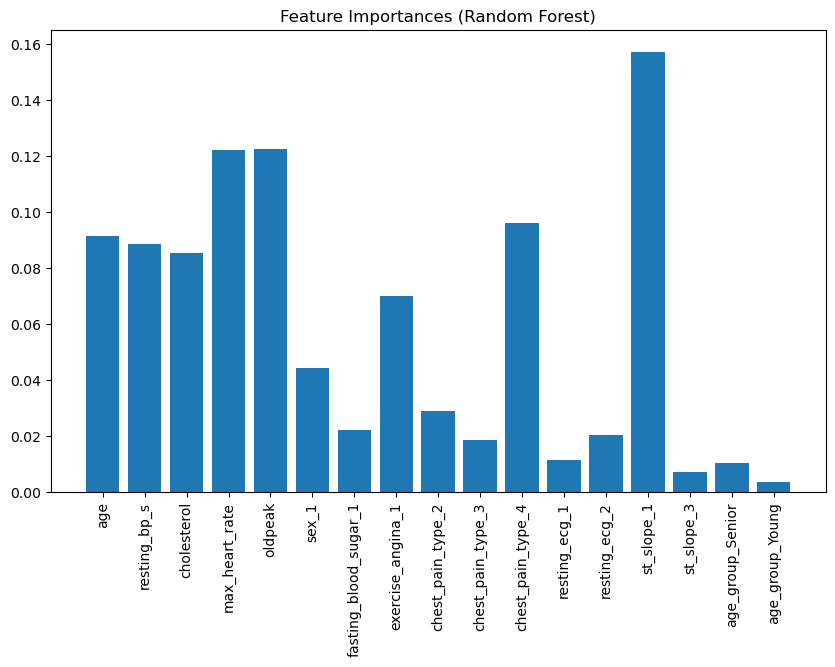


Train F1 Score: 0.854043392504931
Test F1 Score: 0.8604651162790697

Training Confusion Matrix:
TP: 433, TN: 371, FP: 78, FN: 70

Test Confusion Matrix:
TP: 111, TN: 91, FP: 21, FN: 15


2024/12/20 19:11:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LR with Feature Engr and Selection Using Threshold at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/0d8a25249954459fbc2851f07b52eb46
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1

Feature Selection Experiment completed and logged in MLFlow.


In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import matplotlib.pyplot as plt

# Step 1: Reload and Clean Data (from df_combined)
df = df_combined.copy()

def clean_column_names(df):
    df.columns = df.columns.str.replace(' ', '_').str.lower()
    return df

df = clean_column_names(df)

# Data Cleaning
df['resting_bp_s'] = df['resting_bp_s'].replace(0, np.nan)
df['cholesterol'] = df['cholesterol'].replace(0, np.nan)
df['oldpeak'] = df['oldpeak'].clip(lower=0)

df['resting_bp_s'].fillna(df['resting_bp_s'].median(), inplace=True)
df['cholesterol'].fillna(df['cholesterol'].median(), inplace=True)

df = df.drop(columns=['patient_id'], errors='ignore')

# Step 2: Feature Engineering
df['bp_cholesterol_interaction'] = df['resting_bp_s'] * df['cholesterol']
df['age_group'] = pd.cut(df['age'], bins=[0, 40, 60, 80], labels=['Young', 'Middle-aged', 'Senior'])
df['cholesterol_squared'] = df['cholesterol'] ** 2
df['bp_hr_ratio'] = df['resting_bp_s'] / df['max_heart_rate']
df['combined_health_score'] = df[['resting_bp_s', 'cholesterol', 'max_heart_rate']].mean(axis=1)

# Feature List
numeric_features = ['age', 'resting_bp_s', 'cholesterol', 'max_heart_rate', 'oldpeak',
                    'bp_cholesterol_interaction', 'cholesterol_squared', 'bp_hr_ratio', 'combined_health_score']

categorical_features = ['sex', 'fasting_blood_sugar', 'exercise_angina', 
                        'chest_pain_type', 'resting_ecg', 'st_slope', 'age_group']

# Preprocessing: Scaling + Encoding
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Apply preprocessing
X = preprocessor.fit_transform(df.drop(columns=['target']))
y = df['target']

# Extract updated feature names
encoded_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_columns = numeric_features + list(encoded_columns)

# Convert to DataFrame
X = pd.DataFrame(X, columns=all_columns)

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print initial shape and feature names
print(f"Initial Train Data Shape: {X_train.shape}")
print(f"Initial Features: {X_train.columns.tolist()}")

# Step 5: Feature Selection
## 1. Variance Threshold
variance_thresh = VarianceThreshold(threshold=0.01)
X_train_var = variance_thresh.fit_transform(X_train)
X_test_var = variance_thresh.transform(X_test)

# Identify kept and dropped features
kept_features_var = X_train.columns[variance_thresh.get_support()]
dropped_features_var = X_train.columns.difference(kept_features_var)

print(f"\nFeatures Kept After Variance Threshold: {list(kept_features_var)}")
print(f"Features Dropped After Variance Threshold: {list(dropped_features_var)}")
print(f"After Variance Threshold: {X_train_var.shape}")

## 2. Correlation Threshold
corr_matrix = pd.DataFrame(X_train_var, columns=kept_features_var).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.8)]

X_train_corr = pd.DataFrame(X_train_var, columns=kept_features_var).drop(columns=to_drop_corr)
X_test_corr = pd.DataFrame(X_test_var, columns=kept_features_var).drop(columns=to_drop_corr)

print(f"\nFeatures Dropped Due to High Correlation: {to_drop_corr}")
print(f"Features Kept After Correlation Threshold: {X_train_corr.columns.tolist()}")
print(f"After Correlation Threshold: {X_train_corr.shape}")

## 3. Feature Importance (Random Forest)
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')
X_train_selected = selector.fit_transform(X_train_corr, y_train)
X_test_selected = selector.transform(X_test_corr)

# Selected Features
selected_features = X_train_corr.columns[selector.get_support()]
dropped_features_rf = X_train_corr.columns.difference(selected_features)

print(f"\nSelected Features by Random Forest: {list(selected_features)}")
print(f"Features Dropped by Random Forest: {list(dropped_features_rf)}")
print(f"Final Train Data Shape: {X_train_selected.shape}")

# Visualize Feature Importances
importances = selector.estimator_.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(X_train_corr.columns, importances)
plt.xticks(rotation=90)
plt.title("Feature Importances (Random Forest)")
plt.show()

# Step 6: Train Logistic Regression Model
model = LogisticRegression(max_iter=500, random_state=42)
model.fit(X_train_selected, y_train)

# Predictions
y_train_pred = model.predict(X_train_selected)
y_test_pred = model.predict(X_test_selected)

f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Print Confusion Matrices and F1 Scores
tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()

print(f"\nTrain F1 Score: {f1_train}")
print(f"Test F1 Score: {f1_test}")
print("\nTraining Confusion Matrix:")
print(f"TP: {tp_train}, TN: {tn_train}, FP: {fp_train}, FN: {fn_train}")
print("\nTest Confusion Matrix:")
print(f"TP: {tp_test}, TN: {tn_test}, FP: {fp_test}, FN: {fn_test}")

# Step 7: Log Results in MLFlow
mlflow.set_tracking_uri("https://dagshub.com/rohanjain127/my-first-repo.mlflow")
mlflow.set_experiment("Heart Disease Experiment")

with mlflow.start_run(run_name="LR with Feature Engr and Selection Using Threshold"):
    mlflow.log_metric("Train F1 Score", f1_train)
    mlflow.log_metric("Test F1 Score", f1_test)
    mlflow.log_metric("Train True Positives", tp_train)
    mlflow.log_metric("Train True Negatives", tn_train)
    mlflow.log_metric("Test True Positives", tp_test)
    mlflow.log_metric("Test True Negatives", tn_test)
    mlflow.log_param("Selected Features", list(selected_features))
    mlflow.sklearn.log_model(model, "Logistic Regression with Feature Engineering and Selection using Threshold")

print("\nFeature Selection Experiment completed and logged in MLFlow.")


In [36]:
# Logistic Regression with Feature Engineering is slightly better, removing features did not help much

# Experiment #5: Use PCA for dimensionality reduction on all the features. Create a scree plot to show which components will be selected for classification. Log results in MLFlow.

In [37]:
# Approach 1: PCA after Feature Engineering


--- Features Before PCA (After Feature Engineering) ---
['age', 'resting_bp_s', 'cholesterol', 'max_heart_rate', 'oldpeak', 'bp_cholesterol_interaction', 'cholesterol_squared', 'bp_hr_ratio', 'combined_health_score', 'sex_1', 'fasting_blood_sugar_1', 'exercise_angina_1', 'chest_pain_type_2', 'chest_pain_type_3', 'chest_pain_type_4', 'resting_ecg_1', 'resting_ecg_2', 'st_slope_1', 'st_slope_2', 'st_slope_3', 'age_group_Senior', 'age_group_Young']


/var/folders/88/h6q1hd0558n2s59lz2g0xx640000gn/T/ipykernel_61598/2097533184.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['resting_bp_s'].fillna(df['resting_bp_s'].median(), inplace=True)
/var/folders/88/h6q1hd0558n2s59lz2g0xx640000gn/T/ipykernel_61598/2097533184.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

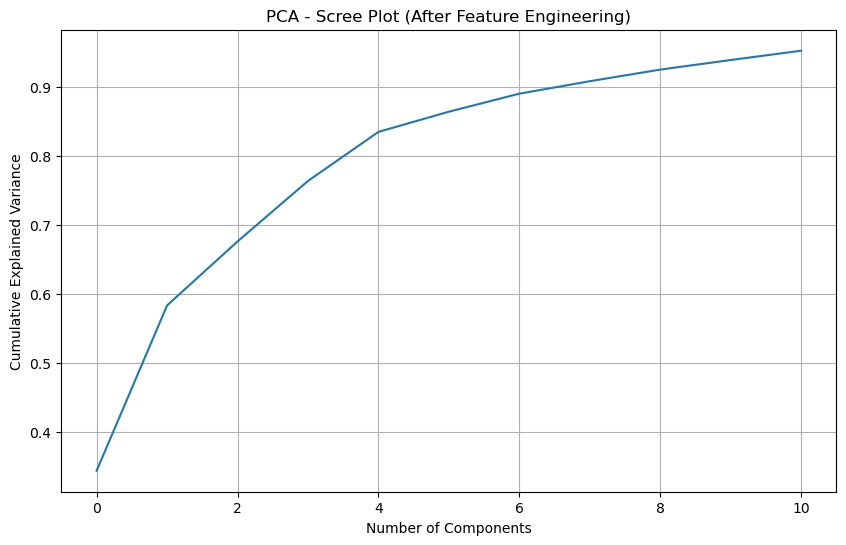


--- Features Kept After PCA ---
['age', 'resting_bp_s', 'cholesterol', 'max_heart_rate', 'oldpeak', 'bp_cholesterol_interaction', 'cholesterol_squared', 'bp_hr_ratio', 'combined_health_score', 'sex_1', 'fasting_blood_sugar_1', 'exercise_angina_1', 'chest_pain_type_2', 'chest_pain_type_3', 'chest_pain_type_4', 'resting_ecg_1', 'resting_ecg_2', 'st_slope_1', 'st_slope_2', 'st_slope_3', 'age_group_Senior', 'age_group_Young']

--- Features Dropped After PCA ---
[]

Training F1 Score: 0.8686274509803922
Test F1 Score: 0.8671875

Training Confusion Matrix: [[375  74]
 [ 60 443]]
Test Confusion Matrix: [[ 93  19]
 [ 15 111]]


2024/12/20 19:11:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run PCA after Feature Engineering at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/35b9ce4ea69347a0aa4f8d4d29e40a7b
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1


In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import matplotlib.pyplot as plt

# Step 1: Data Loading and Cleaning
df = df_combined

def clean_column_names(df):
    df.columns = df.columns.str.replace(' ', '_').str.lower()
    return df

df = clean_column_names(df)

df['resting_bp_s'] = df['resting_bp_s'].replace(0, np.nan)
df['cholesterol'] = df['cholesterol'].replace(0, np.nan)
df['oldpeak'] = df['oldpeak'].clip(lower=0)
df['resting_bp_s'].fillna(df['resting_bp_s'].median(), inplace=True)
df['cholesterol'].fillna(df['cholesterol'].median(), inplace=True)
df.drop(columns=['patient_id'], errors='ignore', inplace=True)

# Step 2: Feature Engineering
df['bp_cholesterol_interaction'] = df['resting_bp_s'] * df['cholesterol']
df['age_group'] = pd.cut(df['age'], bins=[0, 40, 60, 80], labels=['Young', 'Middle-aged', 'Senior'])
df['cholesterol_squared'] = df['cholesterol'] ** 2
df['bp_hr_ratio'] = df['resting_bp_s'] / df['max_heart_rate']
df['combined_health_score'] = df[['resting_bp_s', 'cholesterol', 'max_heart_rate']].mean(axis=1)

# Step 3: Preprocessing
numeric_features = ['age', 'resting_bp_s', 'cholesterol', 'max_heart_rate', 'oldpeak',
                    'bp_cholesterol_interaction', 'cholesterol_squared', 'bp_hr_ratio', 'combined_health_score']
categorical_features = ['sex', 'fasting_blood_sugar', 'exercise_angina', 'chest_pain_type', 'resting_ecg', 'st_slope', 'age_group']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X = preprocessor.fit_transform(df.drop(columns=['target']))
y = df['target']

encoded_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_columns = numeric_features + list(encoded_columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print Features Before PCA
print("\n--- Features Before PCA (After Feature Engineering) ---")
print(all_columns)

# Step 4: PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Scree Plot (After Feature Engineering)')
plt.grid(True)
plt.show()

kept_features = np.sum(pca.components_, axis=0) != 0
kept_feature_names = [all_columns[i] for i, kept in enumerate(kept_features) if kept]
dropped_feature_names = [all_columns[i] for i, kept in enumerate(kept_features) if not kept]

print("\n--- Features Kept After PCA ---")
print(kept_feature_names)
print("\n--- Features Dropped After PCA ---")
print(dropped_feature_names)

model = LogisticRegression(max_iter=500, random_state=42)
model.fit(X_train_pca, y_train)

y_train_pred = model.predict(X_train_pca)
y_test_pred = model.predict(X_test_pca)

f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print("\nTraining F1 Score:", f1_train)
print("Test F1 Score:", f1_test)
print("\nTraining Confusion Matrix:", cm_train)
print("Test Confusion Matrix:", cm_test)

mlflow.set_tracking_uri("https://dagshub.com/rohanjain127/my-first-repo.mlflow")
mlflow.set_experiment("Heart Disease Experiment")

with mlflow.start_run(run_name="PCA after Feature Engineering"):
    mlflow.log_metric("Train F1 Score", f1_train)
    mlflow.log_metric("Test F1 Score", f1_test)
    mlflow.log_param("Kept Features", kept_feature_names)
    mlflow.log_param("Dropped Features", dropped_feature_names)
    mlflow.sklearn.log_model(model, "Logistic Regression with PCA")



--- Features Before PCA (After Feature Selection) ---
['age', 'cholesterol', 'max_heart_rate', 'oldpeak', 'bp_cholesterol_interaction', 'bp_hr_ratio', 'combined_health_score', 'exercise_angina_1', 'chest_pain_type_4', 'st_slope_1', 'st_slope_2']


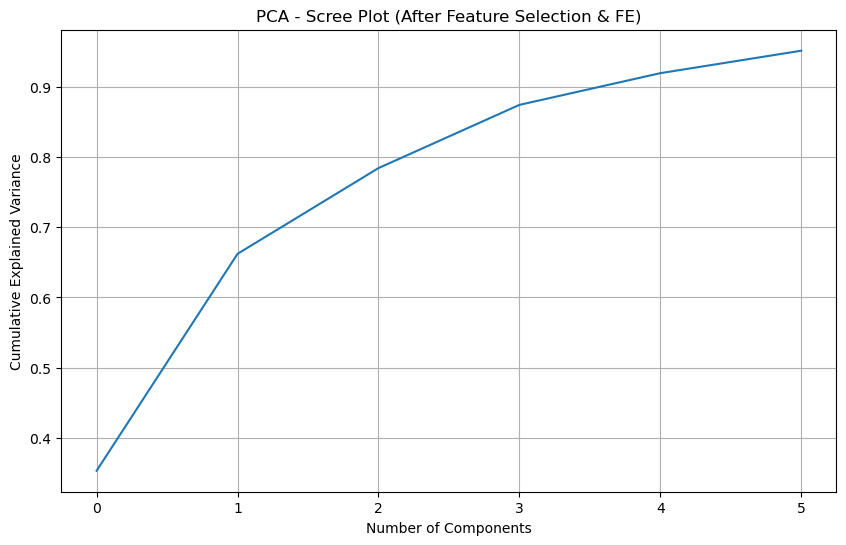


--- Features Kept After PCA ---
['age', 'cholesterol', 'max_heart_rate', 'oldpeak', 'bp_cholesterol_interaction', 'bp_hr_ratio', 'combined_health_score', 'exercise_angina_1', 'chest_pain_type_4', 'st_slope_1', 'st_slope_2']

--- Features Dropped After PCA ---
[]

Training F1 Score: 0.8244575936883629
Test F1 Score: 0.84
🏃 View run PCA after Feature Selection and FE at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/9ef23c5767b547708f2e8add91d3813a
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1


In [39]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_features = pd.DataFrame(X_train, columns=all_columns).columns[selector.get_support()]

print("\n--- Features Before PCA (After Feature Selection) ---")
print(list(selected_features))

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Scree Plot (After Feature Selection & FE)')
plt.grid(True)
plt.show()

kept_features = np.sum(pca.components_, axis=0) != 0
kept_feature_names = [selected_features[i] for i, kept in enumerate(kept_features) if kept]
dropped_feature_names = [selected_features[i] for i, kept in enumerate(kept_features) if not kept]

print("\n--- Features Kept After PCA ---")
print(kept_feature_names)
print("\n--- Features Dropped After PCA ---")
print(dropped_feature_names)

model.fit(X_train_pca, y_train)

y_train_pred = model.predict(X_train_pca)
y_test_pred = model.predict(X_test_pca)

f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print("\nTraining F1 Score:", f1_train)
print("Test F1 Score:", f1_test)

mlflow.set_experiment("Heart Disease Experiment")
with mlflow.start_run(run_name="PCA after Feature Selection and FE"):
    mlflow.log_metric("Train F1 Score", f1_train)
    mlflow.log_metric("Test F1 Score", f1_test)
    mlflow.log_param("Kept Features", kept_feature_names)
    mlflow.log_param("Dropped Features", dropped_feature_names)


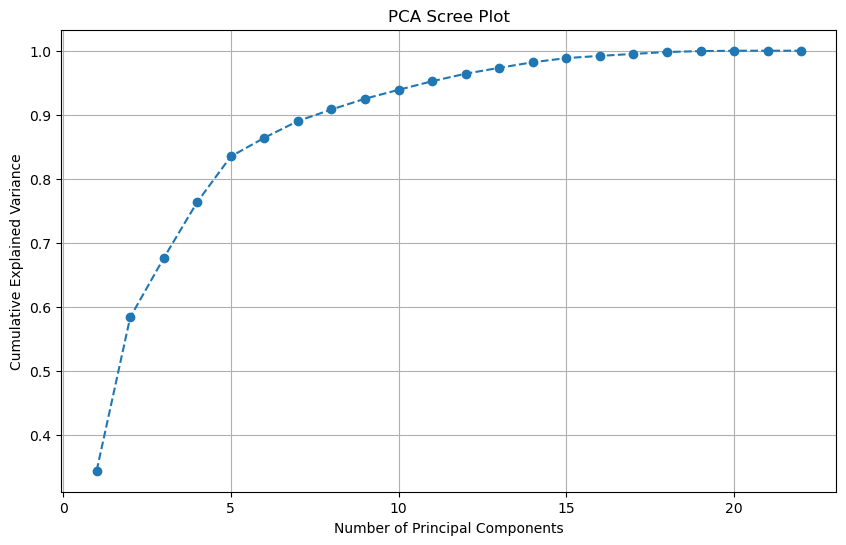

PC 1: Explained Variance Ratio: 0.3434, Cumulative Variance: 0.3434
PC 2: Explained Variance Ratio: 0.2397, Cumulative Variance: 0.5831
PC 3: Explained Variance Ratio: 0.0927, Cumulative Variance: 0.6758
PC 4: Explained Variance Ratio: 0.0877, Cumulative Variance: 0.7635
PC 5: Explained Variance Ratio: 0.0711, Cumulative Variance: 0.8347
PC 6: Explained Variance Ratio: 0.0293, Cumulative Variance: 0.8639
PC 7: Explained Variance Ratio: 0.0261, Cumulative Variance: 0.8901
PC 8: Explained Variance Ratio: 0.0181, Cumulative Variance: 0.9081
PC 9: Explained Variance Ratio: 0.0169, Cumulative Variance: 0.9250
PC 10: Explained Variance Ratio: 0.0139, Cumulative Variance: 0.9389
PC 11: Explained Variance Ratio: 0.0135, Cumulative Variance: 0.9523
PC 12: Explained Variance Ratio: 0.0118, Cumulative Variance: 0.9641
PC 13: Explained Variance Ratio: 0.0091, Cumulative Variance: 0.9732
PC 14: Explained Variance Ratio: 0.0087, Cumulative Variance: 0.9820
PC 15: Explained Variance Ratio: 0.0065, Cu

In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Apply PCA to the training data
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Scree Plot')
plt.grid(True)
plt.show()

# Print variance ratios
for i, (var_ratio, cum_var) in enumerate(zip(explained_variance_ratio, cumulative_variance), 1):
    print(f"PC {i}: Explained Variance Ratio: {var_ratio:.4f}, Cumulative Variance: {cum_var:.4f}")


PC 1: Explained Variance Ratio: 0.3434, Cumulative Variance: 0.3434
PC 2: Explained Variance Ratio: 0.2397, Cumulative Variance: 0.5831
PC 3: Explained Variance Ratio: 0.0927, Cumulative Variance: 0.6758
PC 4: Explained Variance Ratio: 0.0877, Cumulative Variance: 0.7635
PC 5: Explained Variance Ratio: 0.0711, Cumulative Variance: 0.8347
PC 6: Explained Variance Ratio: 0.0293, Cumulative Variance: 0.8639
PC 7: Explained Variance Ratio: 0.0261, Cumulative Variance: 0.8901
PC 8: Explained Variance Ratio: 0.0181, Cumulative Variance: 0.9081
PC 9: Explained Variance Ratio: 0.0169, Cumulative Variance: 0.9250
PC 10: Explained Variance Ratio: 0.0139, Cumulative Variance: 0.9389
PC 11: Explained Variance Ratio: 0.0135, Cumulative Variance: 0.9523
PC 12: Explained Variance Ratio: 0.0118, Cumulative Variance: 0.9641
PC 13: Explained Variance Ratio: 0.0091, Cumulative Variance: 0.9732
PC 14: Explained Variance Ratio: 0.0087, Cumulative Variance: 0.9820
PC 15: Explained Variance Ratio: 0.0065, Cu

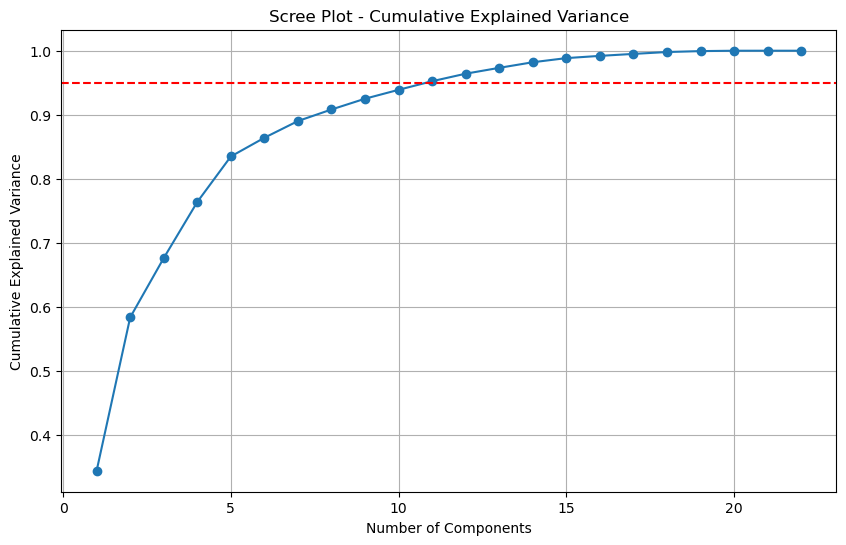


Number of components selected to cover 95% variance: 11

--- Features Kept After PCA ---
['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11']

--- Features Dropped After PCA ---
['PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22']


2024/12/20 19:11:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/12/20 19:11:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/20 19:12:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run PCA and Logistic Regression after compnent reduction at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/0a2d99ca5dc84032936c8a15792c0693
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1

--- Model Performance After PCA ---
Train F1 Score: 0.8686274509803922
Test F1 Score: 0.8671875

Training Confusion Matrix:
TP: 443, TN: 375, FP: 74, FN: 60

Test Confusion Matrix:
TP: 111, TN: 93, FP: 19, FN: 15


In [41]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import matplotlib.pyplot as plt

# Step 1: Perform PCA on the Training Data
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Step 2: Calculate Cumulative Variance to Decide Components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

for i, (var_ratio, cum_var) in enumerate(zip(explained_variance_ratio, cumulative_variance)):
    print(f"PC {i+1}: Explained Variance Ratio: {var_ratio:.4f}, Cumulative Variance: {cum_var:.4f}")

# Plot Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title("Scree Plot - Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

# Step 3: Select Components Covering 95% of Variance
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nNumber of components selected to cover 95% variance: {n_components}")

# Refit PCA with Selected Components
pca_final = PCA(n_components=n_components)
X_train_pca_final = pca_final.fit_transform(X_train)
X_test_pca_final = pca_final.transform(X_test)

# Step 4: Map Retained Features
retained_features = list(pca_final.components_.T @ np.eye(pca_final.n_components_))
retained_features = [f"PC{i+1}" for i in range(n_components)]
dropped_features = [f"PC{i+1}" for i in range(n_components, X_train.shape[1])]

print("\n--- Features Kept After PCA ---")
print(retained_features)

print("\n--- Features Dropped After PCA ---")
print(dropped_features)

# Step 5: Train Logistic Regression on Reduced Data
model = LogisticRegression(max_iter=500, random_state=42)
model.fit(X_train_pca_final, y_train)

# Step 6: Predictions
y_train_pred = model.predict(X_train_pca_final)
y_test_pred = model.predict(X_test_pca_final)

# Step 7: Calculate Metrics
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()

# Step 8: Log Results in MLFlow
mlflow.set_tracking_uri("https://dagshub.com/rohanjain127/my-first-repo.mlflow")
mlflow.set_experiment("Heart Disease Experiment")

with mlflow.start_run(run_name="PCA and Logistic Regression after compnent reduction"):
    # Log metrics
    mlflow.log_metric("Train F1 Score", f1_train)
    mlflow.log_metric("Test F1 Score", f1_test)
    mlflow.log_metric("Train True Positives", tp_train)
    mlflow.log_metric("Train True Negatives", tn_train)
    mlflow.log_metric("Train False Positives", fp_train)
    mlflow.log_metric("Train False Negatives", fn_train)
    mlflow.log_metric("Test True Positives", tp_test)
    mlflow.log_metric("Test True Negatives", tn_test)
    mlflow.log_metric("Test False Positives", fp_test)
    mlflow.log_metric("Test False Negatives", fn_test)
    
    # Log models
    mlflow.sklearn.log_model(pca_final, "PCA Model")
    mlflow.sklearn.log_model(model, "Logistic Regression (PCA)")

    # Log features
    mlflow.log_param("Retained Features", retained_features)
    mlflow.log_param("Dropped Features", dropped_features)

# Print Results
print("\n--- Model Performance After PCA ---")
print(f"Train F1 Score: {f1_train}")
print(f"Test F1 Score: {f1_test}")
print("\nTraining Confusion Matrix:")
print(f"TP: {tp_train}, TN: {tn_train}, FP: {fp_train}, FN: {fn_train}")
print("\nTest Confusion Matrix:")
print(f"TP: {tp_test}, TN: {tn_test}, FP: {fp_test}, FN: {fn_test}")


In [42]:
# Improved a little by dimensionality reduction

# Experiment #6: Design a nd execute a custom experiment. Log results in MLFlow.

# Experiment #7: Design and execute another custom experiment. Log results in MLFlow.

In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score, confusion_matrix
import mlflow

# ----- Load Data -----
df = df_combined.copy()

def clean_column_names(df):
    df.columns = df.columns.str.replace(' ', '_').str.lower()
    return df

df = clean_column_names(df)

# ----- Data Cleaning -----
df['resting_bp_s'] = df['resting_bp_s'].replace(0, np.nan)
df['cholesterol'] = df['cholesterol'].replace(0, np.nan)
df['oldpeak'] = df['oldpeak'].clip(lower=0)
df['resting_bp_s'].fillna(df['resting_bp_s'].median(), inplace=True)
df['cholesterol'].fillna(df['cholesterol'].median(), inplace=True)
df.drop(columns=['patient_id'], errors='ignore', inplace=True)

# ----- Feature Engineering -----
df['bp_cholesterol_interaction'] = df['resting_bp_s'] * df['cholesterol']
df['cholesterol_squared'] = df['cholesterol'] ** 2
df['bp_hr_ratio'] = df['resting_bp_s'] / df['max_heart_rate']
df['combined_health_score'] = df[['resting_bp_s', 'cholesterol', 'max_heart_rate']].mean(axis=1)
df['age_group'] = pd.cut(df['age'], bins=[0, 40, 60, 80], labels=['Young', 'Middle-aged', 'Senior'])

# ----- Preprocessing -----
numeric_features = ['age', 'resting_bp_s', 'cholesterol', 'max_heart_rate', 'oldpeak',
                    'bp_cholesterol_interaction', 'cholesterol_squared', 'bp_hr_ratio', 'combined_health_score']
categorical_features = ['sex', 'fasting_blood_sugar', 'exercise_angina', 'chest_pain_type', 'resting_ecg', 'st_slope', 'age_group']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X = preprocessor.fit_transform(df.drop(columns=['target']))
y = df['target']

X = pd.DataFrame(X, columns=numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# ----- Experiment 6 and 7 Classifiers -----
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=500, random_state=42),
    "RidgeClassifier": RidgeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "SVC": SVC(kernel='rbf', probability=True, random_state=42),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42)
}


# ----- Experiment 6: Feature Engineering Only -----
def run_experiment_6(X_train, X_test, y_train, y_test):
    print("\n--- Experiment 6: Feature Engineering Only ---")
    mlflow.set_experiment("Heart Disease Experiment")

    for name, model in classifiers.items():
        pipeline = Pipeline([('classifier', model)])
        pipeline.fit(X_train, y_train)

        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)

        f1_train = f1_score(y_train, y_train_pred)
        f1_test = f1_score(y_test, y_test_pred)
        cm_train = confusion_matrix(y_train, y_train_pred)
        cm_test = confusion_matrix(y_test, y_test_pred)

        print(f"\n{name} (Feature Engineering):")
        print(f"Train F1 Score: {f1_train}")
        print(f"Test F1 Score: {f1_test}")

        with mlflow.start_run(run_name=f"{name} with Feature Engineering"):
            mlflow.log_metric("Train F1 Score", f1_train)
            mlflow.log_metric("Test F1 Score", f1_test)
            mlflow.log_param("Classifier", name)
            mlflow.sklearn.log_model(pipeline, f"{name}_FE")

run_experiment_6(X_train, X_test, y_train, y_test)


# ----- Experiment 7: Feature Engineering + Feature Selection + PCA -----
def run_experiment_7(X_train, X_test, y_train, y_test):
    print("\n--- Experiment 7: Feature Selection and PCA ---")
    mlflow.set_experiment("Heart Disease Experiment")

    # Feature Selection
    selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # PCA
    pca = PCA(n_components=0.95)  # Keep 95% variance
    X_train_pca = pca.fit_transform(X_train_selected)
    X_test_pca = pca.transform(X_test_selected)

    print("\nPCA Components Retained:", pca.n_components_)

    for name, model in classifiers.items():
        model.fit(X_train_pca, y_train)

        y_train_pred = model.predict(X_train_pca)
        y_test_pred = model.predict(X_test_pca)

        f1_train = f1_score(y_train, y_train_pred)
        f1_test = f1_score(y_test, y_test_pred)

        print(f"\n{name} (Feature Selection + PCA):")
        print(f"Train F1 Score: {f1_train}")
        print(f"Test F1 Score: {f1_test}")

        with mlflow.start_run(run_name=f"{name} with Feature Selection + PCA"):
            mlflow.log_metric("Train F1 Score", f1_train)
            mlflow.log_metric("Test F1 Score", f1_test)
            mlflow.log_param("Classifier", name)
            mlflow.sklearn.log_model(model, f"{name}_FE_FS_PCA")

run_experiment_7(X_train, X_test, y_train, y_test)



--- Experiment 6: Feature Engineering Only ---

LogisticRegression (Feature Engineering):
Train F1 Score: 0.8644400785854617
Test F1 Score: 0.875


/var/folders/88/h6q1hd0558n2s59lz2g0xx640000gn/T/ipykernel_61598/2921495511.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['resting_bp_s'].fillna(df['resting_bp_s'].median(), inplace=True)
/var/folders/88/h6q1hd0558n2s59lz2g0xx640000gn/T/ipykernel_61598/2921495511.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

🏃 View run LogisticRegression with Feature Engineering at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/f5e3a3ec1edc4e6399faa60646645891
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1

RidgeClassifier (Feature Engineering):
Train F1 Score: 0.8565815324165029
Test F1 Score: 0.8715953307392996


2024/12/20 19:12:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RidgeClassifier with Feature Engineering at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/6b6c80ea6bc04eab9fb1ef910a2e1e84
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1

RandomForestClassifier (Feature Engineering):
Train F1 Score: 1.0
Test F1 Score: 0.9173553719008265


2024/12/20 19:12:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier with Feature Engineering at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/f28d311c8c5343e5b258f30cffb085f2
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1

XGBClassifier (Feature Engineering):
Train F1 Score: 1.0
Test F1 Score: 0.9156626506024096


2024/12/20 19:12:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBClassifier with Feature Engineering at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/1c97db6e1f6743debe72190846d81da2
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1

KNeighborsClassifier (Feature Engineering):
Train F1 Score: 0.8888888888888888
Test F1 Score: 0.8790322580645161


2024/12/20 19:13:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run KNeighborsClassifier with Feature Engineering at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/ef56623746cd44bba421cc5d90885655
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1

SVC (Feature Engineering):
Train F1 Score: 0.899009900990099
Test F1 Score: 0.8995983935742972


2024/12/20 19:13:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run SVC with Feature Engineering at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/a5cf281aa40a440db71ca841d30bfcb3
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1

GradientBoostingClassifier (Feature Engineering):
Train F1 Score: 0.95703125
Test F1 Score: 0.9212598425196851


2024/12/20 19:13:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run GradientBoostingClassifier with Feature Engineering at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/e7a38deb76474e2ab18e3b9038c7cd4d
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1

--- Experiment 7: Feature Selection and PCA ---

PCA Components Retained: 6

LogisticRegression (Feature Selection + PCA):
Train F1 Score: 0.8244575936883629
Test F1 Score: 0.84


2024/12/20 19:13:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression with Feature Selection + PCA at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/48c5bbdfac844fb5831a65f419716baf
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1

RidgeClassifier (Feature Selection + PCA):
Train F1 Score: 0.8170128585558852
Test F1 Score: 0.8616600790513834


2024/12/20 19:14:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RidgeClassifier with Feature Selection + PCA at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/04e3026d9257467b982c172419884a11
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1

RandomForestClassifier (Feature Selection + PCA):
Train F1 Score: 1.0
Test F1 Score: 0.9230769230769231


2024/12/20 19:14:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier with Feature Selection + PCA at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/44e345614a1d434cbe33a2a53de620b2
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1

XGBClassifier (Feature Selection + PCA):
Train F1 Score: 1.0
Test F1 Score: 0.8925619834710744


2024/12/20 19:14:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBClassifier with Feature Selection + PCA at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/74fc8b67915d4ad7aa8dfbaf79c4251d
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1

KNeighborsClassifier (Feature Selection + PCA):
Train F1 Score: 0.8712871287128713
Test F1 Score: 0.8433734939759037


2024/12/20 19:14:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run KNeighborsClassifier with Feature Selection + PCA at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/8f7b290e33a34b0dbcdba7b345bc8138
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1

SVC (Feature Selection + PCA):
Train F1 Score: 0.84765625
Test F1 Score: 0.8571428571428571


2024/12/20 19:14:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run SVC with Feature Selection + PCA at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/8eeccf406ed647c5b979776802bb4b89
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1

GradientBoostingClassifier (Feature Selection + PCA):
Train F1 Score: 0.9322865554465162
Test F1 Score: 0.8629032258064516


2024/12/20 19:15:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run GradientBoostingClassifier with Feature Selection + PCA at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1/runs/78d9788fb8324065892b2c3ed26e332d
🧪 View experiment at: https://dagshub.com/rohanjain127/my-first-repo.mlflow/#/experiments/1


In [44]:
import joblib

# Save the best model (XGBClassifier)
best_model = classifiers["XGBClassifier"]
model_path = '/Users/rohanjain/Desktop/Sem1/Prog_DB/Final project/heart_disease_best_model.joblib'

# Save the model using joblib
joblib.dump(best_model, model_path)
print(f"\nBest Model (XGBClassifier) saved to: {model_path}")



Best Model (XGBClassifier) saved to: /Users/rohanjain/Desktop/Sem1/Prog_DB/Final project/heart_disease_best_model.joblib
